In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading and Inspecting

In [21]:
df = pd.read_csv(r"updated_pollution_dataset.csv")
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [23]:
df.drop_duplicates(inplace=True)

In [24]:
for col in df.columns:
    print(f"{col}\n" , df[col].describe() , "\n" , "="*20)

Temperature
 count    5000.000000
mean       30.029020
std         6.720661
min        13.400000
25%        25.100000
50%        29.000000
75%        34.000000
max        58.600000
Name: Temperature, dtype: float64 
Humidity
 count    5000.000000
mean       70.056120
std        15.863577
min        36.000000
25%        58.300000
50%        69.800000
75%        80.300000
max       128.100000
Name: Humidity, dtype: float64 
PM2.5
 count    5000.000000
mean       20.142140
std        24.554546
min         0.000000
25%         4.600000
50%        12.000000
75%        26.100000
max       295.000000
Name: PM2.5, dtype: float64 
PM10
 count    5000.000000
mean       30.218360
std        27.349199
min        -0.200000
25%        12.300000
50%        21.700000
75%        38.100000
max       315.800000
Name: PM10, dtype: float64 
NO2
 count    5000.000000
mean       26.412100
std         8.895356
min         7.400000
25%        20.100000
50%        25.300000
75%        31.900000
max        64.90

In [25]:
df['Air Quality'].unique()

array(['Moderate', 'Good', 'Hazardous', 'Poor'], dtype=object)

In [26]:
quality_mapping = {'Good': 0, 'Moderate': 1, 'Poor': 2, 'Hazardous': 3}
df['Air Quality'] = df['Air Quality'].map(quality_mapping)

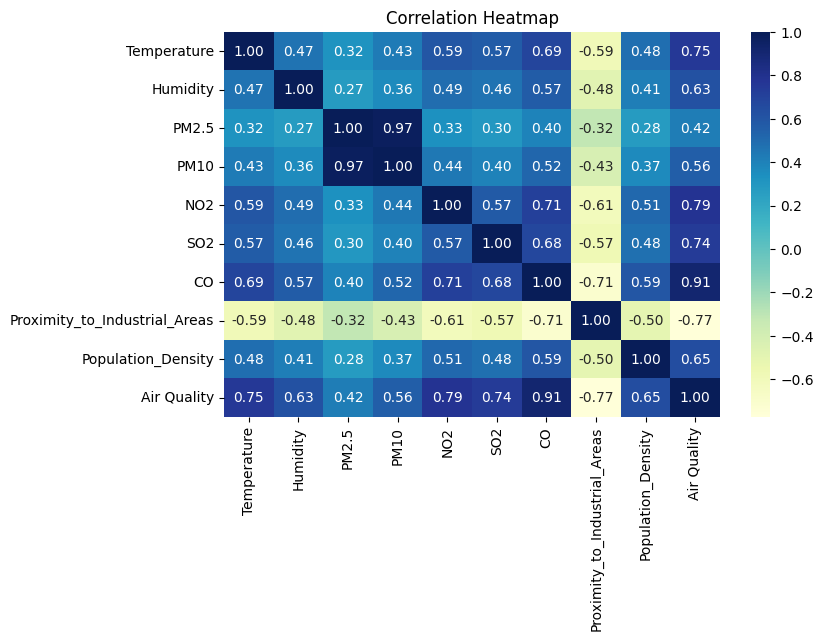

In [27]:
num_df = df.select_dtypes(include="number")

plt.figure(figsize=(8,5))
sns.heatmap(num_df.corr(), annot=True, cmap="YlGnBu", fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

### Correlation Heatmap Analysis

The heatmap presents Pearson correlation coefficients between environmental variables and air quality index (numeric).

#### Strongest Positive Correlations with Air Quality:

- **CO (0.91)** → strongest predictor
- **NO2 (0.79)**
- **SO2 (0.74)**
- **Temperature (0.75)**
- **Population Density (0.65)**

This indicates that gaseous pollutants, especially CO and NO2, have the most significant impact on air quality degradation.

#### Strong Negative Correlation:

- **Proximity to Industrial Areas (-0.77)**  
  Since lower proximity values indicate closer distance, this negative correlation suggests that being closer to industrial areas significantly worsens air quality.

#### Multicollinearity Insight:

- **PM2.5 and PM10 (0.97)** show extremely high correlation.  
  Including both in a regression model may introduce multicollinearity issues.
- CO also correlates strongly with NO2 and SO2, indicating pollutant co-emission sources.

#### Interpretation:

The heatmap confirms that:
- Air quality deterioration is strongly driven by industrial activity and combustion-related gases.
- Pollutants tend to co-vary, suggesting shared emission sources.
- Feature selection or dimensionality reduction may be beneficial before predictive modeling.

Overall, CO appears to be the dominant indicator of air quality in this dataset.


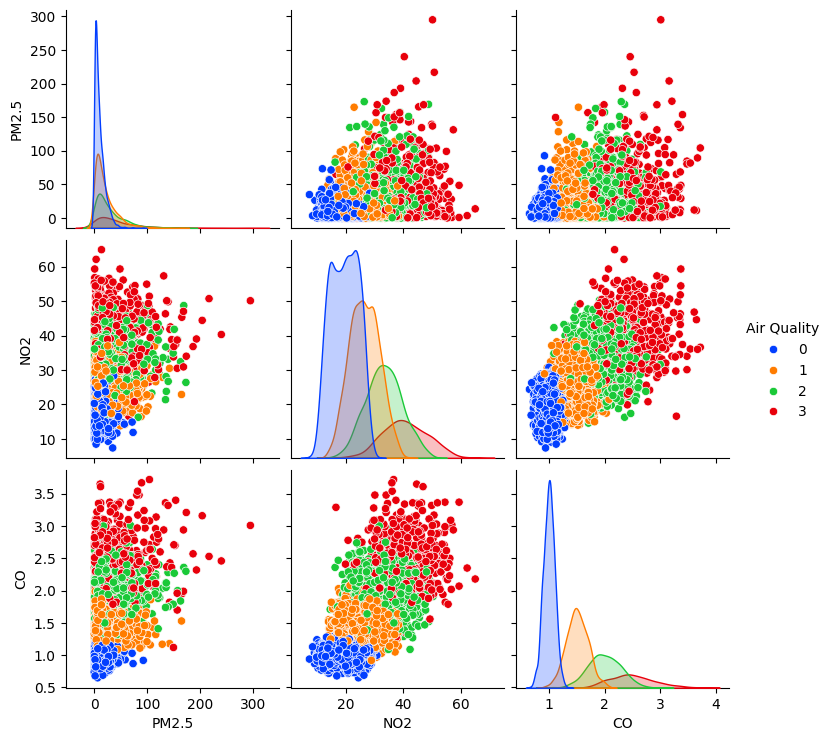

In [28]:
sns.pairplot(df, vars=['PM2.5', 'NO2', 'CO'], 
             hue='Air Quality', palette='bright')
plt.show()

### Pairplot Analysis

The pairplot illustrates the distribution and pairwise relationships between **PM2.5, NO2, and CO**, categorized by air quality levels (Good, Moderate, Poor, Hazardous).

#### Key Observations:

- **Clear class separation**:  
  Air quality categories show a visible upward trend from *Good* to *Hazardous*, with pollutant concentrations increasing consistently.

- **Strong positive relationships**:
  - PM2.5 increases with NO2.
  - PM2.5 increases with CO.
  - NO2 increases with CO.  
  This suggests pollutants tend to rise together rather than independently.

- **Distribution shifts**:
  - *Good* air quality is concentrated at lower pollutant values.
  - *Hazardous* air quality spans the highest concentration ranges with greater spread.
  - Moderate and Poor fall progressively between these extremes.

- **Potential linear separability**:
  The visible clustering suggests that classification models (e.g., Logistic Regression, SVM, Random Forest) could effectively distinguish air quality levels using these features.

Overall, the pairplot confirms that pollutant concentrations strongly influence air quality classification and exhibit correlated behavior.


### Training a Random Forest Model

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

In [30]:
x = df.drop(columns='Air Quality')
y = df['Air Quality']

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4000, 9), (1000, 9), (4000,), (1000,))

In [32]:
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

y_train.shape, y_test.shape

((4000, 1), (1000, 1))

In [33]:
forest = RandomForestClassifier(random_state=42)

forest.fit(x_train, y_train)
y_train_predict = forest.predict(x_train)
y_test_predict = forest.predict(x_test)

c:\Users\omarr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [34]:
print("Training Accuracy : " , accuracy_score(y_train,y_train_predict)*100)
print("Testing Accuracy : " , accuracy_score(y_test,y_test_predict)*100)

Training Accuracy :  100.0
Testing Accuracy :  96.0


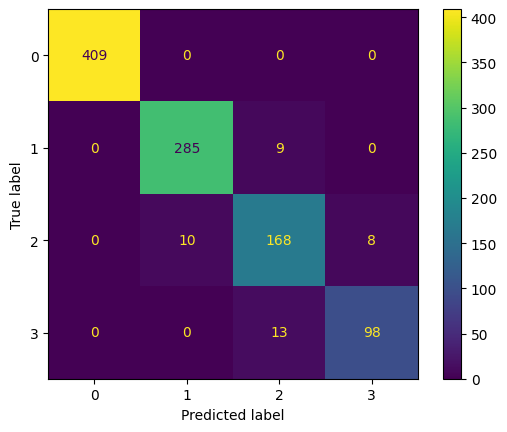

In [35]:
ConfusionMatrixDisplay.from_estimator(forest, x_test, y_test)

### Confusion Matrix Analysis — Random Forest Classifier

The confusion matrix demonstrates strong classification performance of the Random Forest model across all four classes, as evidenced by the clear dominance of diagonal elements over off-diagonal entries.

Class 0 is perfectly classified, achieving 409 correct predictions with no misclassifications, indicating complete separability from the remaining classes in the feature space.

Class 1 achieves high recall, with 285 correctly classified samples and minimal confusion primarily with Class 2 (9 instances).

Class 2 exhibits limited misclassification, with 168 correct predictions and minor confusion distributed between Class 1 (10 instances) and Class 3 (8 instances).

Class 3 is also well classified, with 98 true positives and 13 misclassifications into Class 2.

The observed misclassifications are concentrated between adjacent classes (1 ↔ 2 and 2 ↔ 3), suggesting partial overlap in feature distributions among these categories. However, the overall off-diagonal error rates remain low relative to the total sample counts, indicating strong discriminative capability.

The pronounced diagonal dominance reflects high per-class recall and overall predictive reliability. Overall, these results indicate that the Random Forest classifier achieves robust generalization performance, with errors largely confined to boundary regions between structurally similar classes.


In [36]:
print("Classification Report:\n", classification_report(y_test, y_test_predict))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.97      0.97      0.97       294
           2       0.88      0.90      0.89       186
           3       0.92      0.88      0.90       111

    accuracy                           0.96      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.96      0.96      0.96      1000



## Classification Report Insights

The model demonstrates **strong overall performance** with an accuracy of **96%**.  

- **Class 0** is predicted perfectly with precision, recall, and F1-score all at **1.00**.  
- **Class 1** also shows very high performance (Precision = 0.97, Recall = 0.97, F1 = 0.97).  
- **Class 2** is slightly weaker (Precision = 0.88, Recall = 0.90, F1 = 0.89), indicating occasional confusion with other classes.  
- **Class 3** has good precision (0.92) but slightly lower recall (0.88), meaning some instances of this class are missed.  

The **macro-average** scores (Precision, Recall, F1 = 0.94) indicate balanced performance across all classes, while the **weighted-average** scores (Precision, Recall, F1 = 0.96) reflect the influence of larger classes.  

**Key takeaway:** The model is highly reliable for majority classes, while minority classes could benefit from additional focus to improve recall. Overall, this is a strong multi-class classifier.


### Training Boost Models

In [37]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [44]:
boost_classifiers = {'Adaptive Boost':AdaBoostClassifier(),
                     'Gradient Boost':GradientBoostingClassifier(),
                     'Extreme Gradient Boost':XGBClassifier(),
                     'Light Gradient Boost':LGBMClassifier(),
                     'Categorical Boost':CatBoostClassifier(verbose=0)}

for name, model in boost_classifiers.items():
    model.fit(x_train, y_train)
    y_test_predict = model.predict(x_test)
    print(f"{name} Model Performance:")
    print("Classification Report:\n", classification_report(y_test, y_test_predict))
    print("="*50)

c:\Users\omarr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\omarr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:120: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Adaptive Boost Model Performance:
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.58      0.73       409
           1       0.59      0.89      0.71       294
           2       0.72      0.88      0.79       186
           3       0.86      0.70      0.77       111

    accuracy                           0.74      1000
   macro avg       0.79      0.76      0.75      1000
weighted avg       0.81      0.74      0.74      1000

Gradient Boost Model Performance:
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       409
           1       0.97      0.96      0.96       294
           2       0.88      0.90      0.89       186
           3       0.91      0.86      0.89       111

    accuracy                           0.95      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.96      0.95      0.95      1000

Extreme Gradie

c:\Users\omarr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:103: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\omarr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:139: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Light Gradient Boost Model Performance:
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.97      0.97      0.97       294
           2       0.88      0.91      0.90       186
           3       0.93      0.89      0.91       111

    accuracy                           0.96      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.96      0.96      0.96      1000

Categorical Boost Model Performance:
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.97      0.96      0.96       294
           2       0.87      0.90      0.88       186
           3       0.92      0.88      0.90       111

    accuracy                           0.96      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.96      0.96      0.96      1000



## Boosting Models Performance Summary

### **1. Adaptive Boost (AdaBoost)**
- **Accuracy:** 0.74  
- **Insights:**  
  - Class 0: Perfect precision (1.00) but lower recall (0.58) → many class 0 instances are misclassified.  
  - Class 1: High recall (0.89) but lower precision (0.59) → some misclassified as other classes.  
  - Classes 2 & 3: Reasonable performance with F1-scores around 0.77–0.79.  
- **Key takeaway:** AdaBoost struggles with class balance and misclassifies minority/majority classes; overall performance is moderate.

---

### **2. Gradient Boost (GradientBoostingClassifier)**
- **Accuracy:** 0.95  
- **Insights:**  
  - Classes 0 & 1: Excellent performance (precision and recall ~0.96–1.00).  
  - Classes 2 & 3: Slightly lower but strong F1-scores (~0.86–0.90).  
- **Key takeaway:** Very strong multi-class performance; better at handling minority classes compared to AdaBoost.

---

### **3. Extreme Gradient Boost (XGBoost)**
- **Accuracy:** 0.95  
- **Insights:**  
  - Class 0: Perfect prediction.  
  - Class 1: Very high precision and recall (0.96 & 0.95).  
  - Classes 2 & 3: Slightly lower but still strong (~0.88–0.91 F1).  
- **Key takeaway:** Comparable to Gradient Boost; slightly higher F1 for class 3. Reliable across all classes.

---

### **4. Light Gradient Boost (LightGBM)**
- **Accuracy:** 0.96  
- **Insights:**  
  - Class 0: Perfect.  
  - Classes 1–3: High precision and recall (0.88–0.97 range).  
- **Key takeaway:** Best overall performance among all models, especially for minority classes. High reliability and balanced performance.

---

### **5. Categorical Boost (CatBoost)**
- **Accuracy:** 0.96  
- **Insights:**  
  - Class 0: Perfect.  
  - Classes 1–3: Strong F1-scores (0.88–0.96).  
- **Key takeaway:** Excellent multi-class classifier; handles categorical features well, with slightly better stability than LightGBM in some classes.

---

### **Overall Comparison**
- **Top performers:** LightGBM & CatBoost (accuracy 0.96)  
- **Strong models:** Gradient Boost & XGBoost (accuracy 0.95)  
- **Moderate performance:** AdaBoost (accuracy 0.74)  
- **Observations:**  
  - Adaptive Boost struggles with class imbalance.  
  - Modern gradient boosting models (LightGBM, CatBoost, XGBoost) handle all classes reliably.  
  - Minority classes (2 & 3) are best predicted by LightGBM and CatBoost.

